# AI Workshop - Lab 2-2: Intent Classification

In this lab, we’ll build a system to classify customer text messages into different categories (called **intents**) using a powerful type of AI model called a transformer. Transformers are a key technology behind tools like ChatGPT and other modern language systems.

### Data Overview

We’re working with a dataset of customer text messages that has already been labeled with their intent (e.g., "Order Status", "Product Inquiry", "Account Help"). The goal is to teach the model to recognize these patterns so it can classify new messages correctly.

- **Number of Categories**: 27 different intents.

### What You’ll Learn
- **Transformers**: Get an introduction to these models and why they’re so powerful for language tasks.
- **Model Evaluation**: Understand how to measure a model’s performance and interpret its predictions.

In [1]:
!pip install -Uq datasets transformers accelerate evaluate sentencepiece sacremoses

For this lab, it's essential that we have a GPU available to speed up training. On Google Colab, you can enable a GPU by going to **Runtime** > **Change runtime type** > **Hardware accelerator** > **GPU**.

The following line of code will check if a GPU is available:

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU is available!')
else:
    print('GPU is not available. Enable a GPU runtime in Colab under "Runtime" > "Change runtime type".')

GPU is available!


### Loading the Dataset

Now that we’ve set up our environment and imported the necessary packages, let’s begin by loading our dataset.

In this lab, we’ll work with a dataset of **customer text messages** that have been labeled with their **intent**. Each sample in the dataset includes a text message and a corresponding label indicating the intent behind the message (e.g., inquiry, complaint, order request). This dataset will allow us to build and evaluate models for intent classification.

#### Steps:
1. **Load the Dataset**:
   - Use the `load_dataset` function from the `datasets` library to download and load the dataset.
   - The dataset we’re using is hosted at `"alexwaolson/customer-intents"`.
2. **Inspect the Dataset**:
   - After loading, examine the training split (`intents['train']`) to understand its structure and the data it contains.

In [3]:
from datasets import load_dataset
import pandas as pd

# Load the customer intents dataset
intents = load_dataset("alexwaolson/customer-intents")

# Display the training split
pd.DataFrame(intents['train'])

,message,label
0,acn uhelp me to download my bill from Anna Fre...,get invoice
1,I need to notify of payment errors,payment issue
2,I'm trying to open an standard account for my ...,create account
3,checking invoices from Mr. Jones,check invoice
4,I am waiting for a restitution of 1200 dollars,track refund
...,...,...
1550,mail me my invoice from Anna Freeman,get invoice
1551,I have problems setting up another delivery ad...,set up shipping address
1552,is it possible to check what payment options y...,check payment methods
1553,have a question about a lost padsword,recover password


The dataset consists of two key columns:
- **`message`**: Contains the text of the customer message.
- **`label`**: Contains the intent category for each message.

There are **27 possible intent categories** in this dataset. To understand the distribution of these categories, we can count the number of examples for each intent. This helps us determine whether the dataset is balanced (i.e., whether all categories have similar representation) or imbalanced (some categories have significantly more or fewer samples than others).

Run the code below to calculate the distribution of intent labels:

Number of unique intents: 27


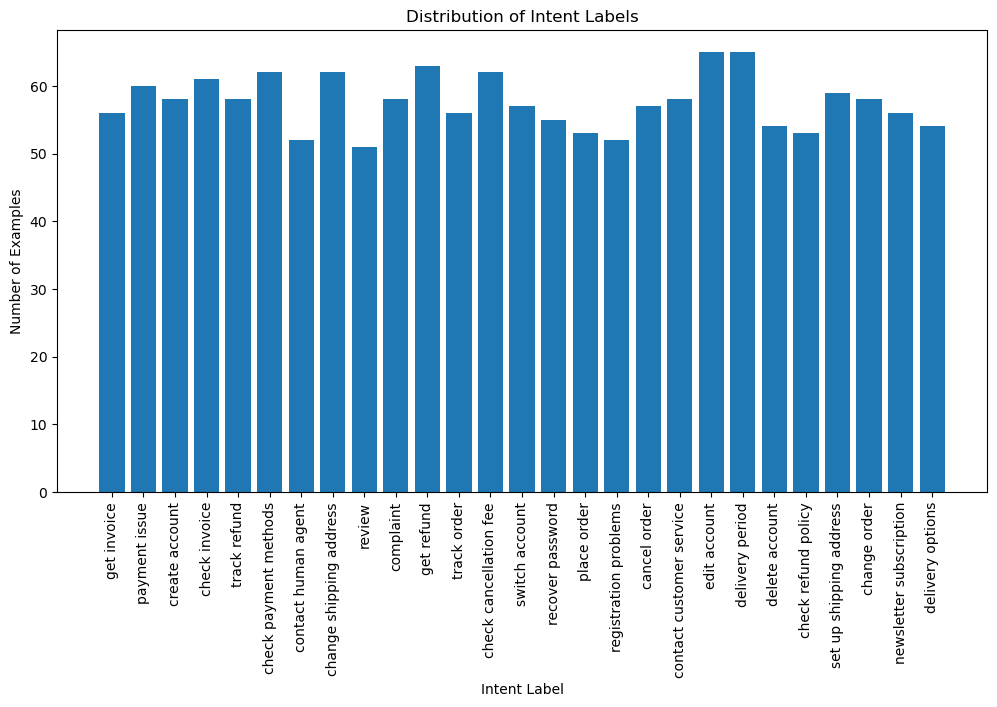

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each intent label in the training data
label_counts = Counter(intents['train']['label'])
print(f'Number of unique intents: {len(label_counts)}')

# Plot the distribution of intent labels
plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Intent Label')
plt.ylabel('Number of Examples')
plt.title('Distribution of Intent Labels')
plt.xticks(rotation=90)
plt.show()

### Zero-Shot Learning

One of the most powerful features of large language models is their ability to perform **zero-shot learning**. Unlike traditional models that require task-specific training, a zero-shot learning model can classify text based on its general understanding of language, even if it hasn’t been explicitly trained on that specific task.

#### How It Works:
- Instead of fine-tuning the model, you provide it with a **prompt** that describes the task and possible labels (e.g., "What is the intent of this message?").
- The model uses its pre-trained knowledge to predict the most appropriate label.

This approach leverages the model's extensive training on a wide variety of text, making it flexible for many tasks.

#### Why Use Zero-Shot Learning?
- **Quick Prototyping**: No need to preprocess or fine-tune the model for every new task.
- **Versatility**: Works for tasks the model wasn’t explicitly trained on, as long as the task can be described in a prompt.

#### Model Selection:
For zero-shot classification, we’ll use the `flan-t5-large` model, which is well suited for this task due to its size and broad understanding of language. Since this model doesn’t require fine-tuning, we can focus on testing its performance directly.

### Zero-Shot Intent Classification with Flan-T5

We’ll now use the **Flan-T5 large** model to classify intents via zero-shot learning. This approach involves crafting a **prompt** that describes the task and provides the model with the possible labels. The model then uses its language understanding to predict the intent without task-specific training.

#### Prompt Construction
The prompt is key to zero-shot learning. For our task:
1. The prompt begins by instructing the model to classify the intent of the message.
2. It lists the available intent categories.
3. Finally, it appends the message to classify.

In [5]:
# Define the prompt
prompt = "Classify the intent of the following message using these categories:\n"
for label in label_counts.keys():
    prompt += f"- {label}\n"
prompt += "Message: "

print(prompt)

Classify the intent of the following message using these categories:
- get invoice
- payment issue
- create account
- check invoice
- track refund
- check payment methods
- contact human agent
- change shipping address
- review
- complaint
- get refund
- track order
- check cancellation fee
- switch account
- recover password
- place order
- registration problems
- cancel order
- contact customer service
- edit account
- delivery period
- delete account
- check refund policy
- set up shipping address
- change order
- newsletter subscription
- delivery options
Message: 


In [6]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="cuda" if torch.cuda.is_available() else "cpu")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
# Function for zero-shot classification
def zero_shot_intent_classification(model, prompt, message):
    # Combine the prompt and the message
    input_text = prompt + message
    # Tokenize the input text
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    # Generate a prediction
    output = model.generate(input_ids, max_length=50, num_beams=5, early_stopping=True)
    # Decode the prediction into text
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Test the function
zero_shot_intent_classification(model, prompt, "I need to cancel my order")

'cancel order'

### Testing Zero-Shot Intent Classification

You can now test the zero-shot classification capabilities of the `flan-t5-large` model on a subset of messages from the test set. This will provide a sense of how well the model performs without task-specific training.

In [8]:
for message in intents['test']['message'][25:35]:
    print(f"Message: {message}")
    print(f"Predicted Intent: {zero_shot_intent_classification(model, prompt, message)}")
    print()

Message: delete Gold account
Predicted Intent: delete account

Message: I am trying to unsubscribe to the newsletter
Predicted Intent: newsletter subscription

Message: what do I need to do to change to the free account?
Predicted Intent: switch account

Message: open anotherstandard account
Predicted Intent: create account

Message: I'd like to switch to the damn Premium account how to do it
Predicted Intent: switch account

Message: editing standard account
Predicted Intent: edit account

Message: wanna order several items help me
Predicted Intent: place order

Message: problems with standard account terminations
Predicted Intent: contact customer service

Message: want help ti earn some of ur product
Predicted Intent: place order

Message: I need help notifying of a trouble with online payment
Predicted Intent: payment issue



### Predicting Intent At Scale

To evaluate the performance of the `flan-t5-large` zero-shot model on the entire test dataset, we’ll:
1. **Generate Predictions**: Use the `zero_shot_intent_classification` function to predict intents for all test messages.
2. **Compare Predictions**: Compare the zero-shot predictions to the true labels in the test set.
3. **Examine mis-classified text**: Look at incorrectly classified examples to see if we can understand what went wrong.

In [9]:
from tqdm import tqdm

zero_shot_predictions = [zero_shot_intent_classification(model, prompt, message) for message in tqdm(intents['test']['message'])]
true_labels_text = intents['test']['label']

100%|██████████| 389/389 [00:44<00:00,  8.68it/s]


In [10]:
from sklearn.metrics import accuracy_score

print(f'Accuracy: {accuracy_score(true_labels_text, zero_shot_predictions)}')

Accuracy: 0.712082262210797


Incredibly, our accuracy using zero-shot learning is around **70%**, even without training on the categories first! Let's take a look at accuracy by category to see if there are any that the model struggles on. The **classification report** will break down the performance of the model by category, allowing us to understand if some categories are less well supported by the model than others. It provides us with the following information:

- **Precision**: This measures the proportion of correctly predicted positive observations to the total predicted positives. High precision indicates that the model makes few false positive errors.

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$

  - **Example**: If the task is to classify emails as "spam," a **true positive** is an email correctly classified as spam, while a **false positive** is a legitimate email incorrectly classified as spam.

- **Recall**: This measures the proportion of correctly predicted positive observations to all the actual positives. High recall indicates that the model captures most of the true positive cases.

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

  - **Example**: In the same email classification task, a **true positive** is an email correctly classified as spam, while a **false negative** is a spam email incorrectly classified as legitimate.

- **F1 Score**: This is the harmonic mean of precision and recall, balancing the two metrics. A high F1 score indicates a good trade-off between precision and recall.

  $$
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **Support**: This refers to the number of actual occurrences of each category in the dataset. It helps us understand the distribution of the categories and whether any are underrepresented, which can impact performance metrics.

In [11]:
from sklearn.metrics import classification_report

print(classification_report(true_labels_text, zero_shot_predictions, zero_division=0))

                          precision    recall  f1-score   support

            cancel order       0.75      0.64      0.69        14
            change order       1.00      0.50      0.67        18
 change shipping address       0.28      1.00      0.43         8
  check cancellation fee       1.00      0.73      0.84        11
           check invoice       1.00      0.46      0.63        13
   check payment methods       1.00      1.00      1.00        13
     check refund policy       0.79      0.94      0.86        16
               complaint       1.00      0.54      0.70        13
contact customer service       0.16      0.73      0.26        11
     contact human agent       0.74      1.00      0.85        20
          create account       0.73      1.00      0.84        16
          delete account       1.00      0.78      0.88        18
        delivery options       1.00      0.18      0.30        17
         delivery period       1.00      0.60      0.75        10
         

Let's now look at some mis-classified examples to see if we can understand why they were not classified correctly.

In [12]:
# Display mis-classified examples
misclassified_examples = [(message, true_label, pred) for message, true_label, pred in zip(intents['test']['message'], true_labels_text, zero_shot_predictions) if true_label != pred]
pd.DataFrame(misclassified_examples, columns=['Message', 'True Label', 'Predicted Label'])

,Message,True Label,Predicted Label
0,I have to see how long it takes for the packag...,delivery period,track order
1,how do I file a customer claim against your or...,complaint,contact customer service
2,question about cancelling purchase 732201349959,cancel order,contact customer service
3,I xepect a compensation of $1499,track refund,get refund
4,problems with standard account terminations,delete account,contact customer service
...,...,...,...
107,reporting issues creating user,registration problems,create account
108,problems with canceling purchase 370795561790,cancel order,contact customer service
109,can you help me to use the Pro profile?,switch account,contact customer service
110,what do I have to do to file a claim?,complaint,contact customer service


### Flagging Abuse

One of the challenges in customer service is identifying and handling abusive messages. Even in this dataset there are examples where customers have used inappropriate language in their requests.

In [13]:
# Display abusive examples
pd.DataFrame([(message, label) for message, label in zip(intents['test']['message'], true_labels_text) if 'damn' in message.lower()], columns=['Message', 'Label'])

,Message,Label
0,i have got to request goddamn erimbursements o...,get refund
1,I'd like to switch to the damn Premium account...,switch account
2,i cannot sign up where to notify of goddamn si...,registration problems
3,I don't know how to demand a goddamn restituti...,get refund
4,can you help me informing of a goddamn signup ...,registration problems
5,"I need a damn Platinum account, could I open it?",create account
6,could you help me to close the damn free account?,delete account
7,I want to delete a goddamn item from order 732...,change order
8,I call to check what damn shipping methods are...,delivery options
9,where can I see what damn shipment options you...,delivery options


Let's say that we want to introduce a new task to classify messages as abusive or not. We can use the same zero-shot approach to classify messages as abusive or not abusive. The prompt will be similar to the previous one, but with the new task and labels.

In [14]:
# Define the prompt for abusive language classification
abuse_prompt = "Classify the following as inappropriate if it contains cursing. Options:\n-Inappropriate\n-Appropriate\nMessage: "

# Load the tokenizer and model
abuse_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
abuse_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="cuda" if torch.cuda.is_available() else "cpu")

# Function for zero-shot classification of abusive language
def zero_shot_abuse_classification(model, prompt, message):
    # Combine the prompt and the message
    input_text = prompt + message
    # Tokenize the input text
    input_ids = abuse_tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    # Generate a prediction
    output = model.generate(input_ids, max_length=50, num_beams=5, early_stopping=True)
    # Decode the prediction into text
    return abuse_tokenizer.decode(output[0], skip_special_tokens=True)

# Test the function
zero_shot_abuse_classification(abuse_model, abuse_prompt, "I'm so damn frustrated with your service!")

'Inappropriate'

Now we can use the model to flag messages as inappropriate or not inappropriate:

In [15]:
# Predict for samples that contain the word "damn"
for message in intents['test']['message']:
    if 'damn' in message.lower():
        print(f"Message: {message}")
        print(f"Predicted Intent: {zero_shot_abuse_classification(abuse_model, abuse_prompt, message)}")
        print()

Message: i have got to request goddamn erimbursements of my money
Predicted Intent: Inappropriate

Message: I'd like to switch to the damn Premium account how to do it
Predicted Intent: Inappropriate

Message: i cannot sign up where to notify of goddamn signup problems
Predicted Intent: Inappropriate

Message: I don't know how to demand a goddamn restitution of my money
Predicted Intent: Inappropriate

Message: can you help me informing of a goddamn signup issue?
Predicted Intent: Inappropriate

Message: I need a damn Platinum account, could I open it?
Predicted Intent: Inappropriate

Message: could you help me to close the damn free account?
Predicted Intent: Inappropriate

Message: I want to delete a goddamn item from order 732201349959
Predicted Intent: Inappropriate

Message: I call to check what damn shipping methods are available
Predicted Intent: Inappropriate

Message: where can I see what damn shipment options you offer?
Predicted Intent: Inappropriate



### Translation

Finally, let's explore how we can use transformers for translation tasks. We'll start by translating English messages to French using the `translation_en_to_fr` pipeline. Then we'll look at translating to Japanese using a different model.

In [16]:
from transformers import pipeline

en_fr_translator = pipeline("translation_en_to_fr", device='cuda')

# Translate a sample message
en_message = "I need help with my order."

en_fr_translator(en_message)

No model was supplied, defaulted to google-t5/t5-base and revision a9723ea (https://huggingface.co/google-t5/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'translation_text': "J'ai besoin d'aide pour faire ma commande."}]

In [17]:
# Translate first 50 messages in the test set
en_messages = intents['test']['message'][:50]
fr_messages = en_fr_translator(en_messages)

# Display the translations
for en_message, fr_message in zip(en_messages, fr_messages):
    print(f"EN: {en_message}\nFR: {fr_message['translation_text']}\n")

EN: I do not know how I can get the bill from Anna Freeman
FR: Je ne sais pas comment obtenir la facture d'Anna Freeman

EN: help me to check how long it takes for my item to arrive
FR: Aidez-moi à vérifier combien de temps il faut pour que mon article arrive

EN: I have to see how long it takes for the package to arrive
FR: Je dois voir combien de temps il faut pour que le colis arrive.

EN: how do I file a customer claim against your organization?
FR: Comment puis-je déposer une réclamation à l'encontre de votre organisation?

EN: I need help to see in what cases can I ask for refunds
FR: J'ai besoin d'aide pour savoir dans quels cas je peux demander des remboursements

EN: i try to talk to an agent
FR: j'essaie de parler à un agent

EN: i dont know what i have to do to buy some of ur product
FR: Je ne sais pas ce que je dois faire pour acheter une partie de votre produit.

EN: help to notify of an payment error
FR: aider à notifier une erreur de paiement

EN: chat wth somebody
FR: c

We can also try translation to Japanese, although be aware that this model is not as effective as the English to French model above.

In [18]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the model and tokenizer
model_name = "Helsinki-NLP/opus-mt-en-jap"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def translate_message(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model.generate(**inputs)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [19]:
translate_message("This is a test message.")

'これ が ため に , あいさつ で あ る .'

In [20]:
# Translate first 50 messages in the test set
en_messages = intents['test']['message'][:50]

for en_message in en_messages:
  print(f"EN: {en_message}\nJP: {translate_message(en_message)}\n")

EN: I do not know how I can get the bill from Anna Freeman
JP: わたし は 知 ら な い の か , 報告 を し て み る が よ い .

EN: help me to check how long it takes for my item to arrive
JP: わたし を 久し く 攻め る ため に , わたし を 助け て くださ い .

EN: I have to see how long it takes for the package to arrive
JP: わたし は 見 て い る 間 は , どう し て い る か を 知 ろ う .

EN: how do I file a customer claim against your organization?
JP: わたし は , なん の ため に , あなた の 寛容 を むさぼり わずら っ て い る の か .

EN: I need help to see in what cases can I ask for refunds
JP: わたし は , どんな 場合 に も , 足 る こと が でき る か を 見 る こと が でき る .

EN: i try to talk to an agent
JP: 世 に あ る こと を 語 る ため に 語 る べ き で あ っ て ,

EN: i dont know what i have to do to buy some of ur product
JP: わたし たち の 中 の  誓 っ て い る こと を , あらかじめ 知 り に し て もら い た い .

EN: help to notify of an payment error
JP: 誘惑 に 陥 ら な い よう に する ため で あ る .

EN: chat wth somebody
JP: アビム は ,  くれ た 者 は , むち を も っ て 道を し て い る .

EN: i have got to request goddamn erimbursements of my money
JP: かえって 神 に 祈 る こと を 求め て , その